In [ ]:
import numpy as np
import scipy as sc
import scipy.io
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import tifffile
from PIL import Image
from scipy.sparse.linalg import LinearOperator
from IPython import display
import time
%matplotlib inline


In [2]:
#psf_in = sc.io.loadmat('/Users/nick.antipa/Documents/psf10time_1_2xds_bgrm_hotpixcorr.mat')
psf_bg = tifffile.imread('/Users/nick.antipa/Documents/Diffusers/Miniscope/RandoscopeNanoscribe/RandoscopeNanoscribe/4_8_bck_1/bck_4_8_ (175).tif')
psf_in = tifffile.imread('/Users/nick.antipa/Documents/Diffusers/Miniscope/RandoscopeNanoscribe/RandoscopeNanoscribe/4_8_psf_1/psf_4_8_ (175).tif')

In [6]:
def imds(x):
    return (x[::2,::2] + x[::2,1::2] + x[1::2,::2] + x[1::2,1::2])/4

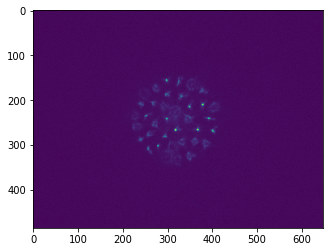

In [7]:
# Asymmetric least squares to estimate background in PSFs.
#psf = np.array(Image.open('/Users/nick.antipa/Documents/Diffusers/Miniscope/RandoscopeV1/randoscope_v1/randoscope_v1/psf_bgrm_100bias_16bit/zstack__100.png'))

psf = imds(imds(psf_in.astype(float) - psf_bg.astype(float)));
# psf = Image.open('/Users/nick.antipa/Downloads/z010.png')
# psf = psf.resize((psf.size[0]//4,psf.size[1]//4),resample=Image.BOX)
# psf = np.array(psf)
# plt.figure()
plt.imshow(psf)

array([[ 2.625 , -4.6875, -4.6875, ..., -1.6875, -2.1875, -0.25  ],
       [ 4.9375,  6.75  ,  2.3125, ...,  6.8125,  2.875 ,  2.625 ],
       [ 4.3125,  2.    , -6.5625, ...,  1.875 , -0.9375,  0.5   ],
       ...,
       [-5.3125,  4.5625,  1.0625, ...,  5.8125, 11.6875,  2.0625],
       [ 3.5625,  3.375 ,  7.4375, ..., -4.125 ,  2.75  , 13.0625],
       [ 6.0625, -5.75  , -5.625 , ...,  6.4375,  7.25  ,  9.4375]])

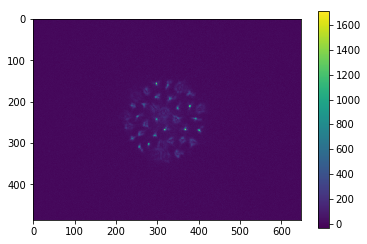

In [8]:
plt.figure()
plt.imshow(psf)
plt.colorbar()
sh = np.shape(psf)
np.reshape(psf.ravel(),sh)

(400, 600)

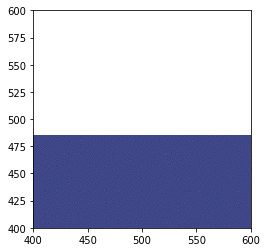

In [9]:
nouter = 10
p = .01
W = np.ones_like(psf)
D = np.zeros_like(psf)
D[0,0]=4
D[0,1]=-1
D[1,0]=-1
D[0,-1]=-1
D[-1,0]=-1
Ds = np.real(np.fft.fft2(D))
lam = 10000

def DtD(x,D):
    return(np.real(np.fft.ifft2(np.fft.fft2(x)*D)))


def als_lhs(z): #, W, lam, Ds, sh):
    # Compute (W+ lam*DtD)z
    z = np.reshape(z,sh)
    return (W*z + lam*DtD(z,Ds)).ravel()


A = LinearOperator((np.prod(sh), np.prod(sh)), matvec = als_lhs)
#test = als_lhs(psf, W, 10000, Ds, sh)
plt.figure()
plt.imshow(np.reshape(A(psf.ravel()),sh))
plt.ylim(400, 600)
plt.xlim(400, 600)


(486, 648)
(486, 648)
(486, 648)


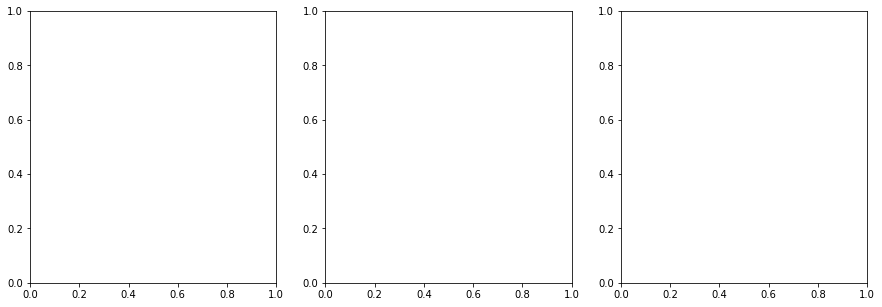

In [22]:
print(np.shape(W))
print(np.shape(psf))
print(np.shape(Ds))
Wy = (W*psf).ravel()
y = psf
z = psf
p = .01
lam = 100000
fig, ax = plt.subplots(1,3,figsize=(15,5))
nouter = 20

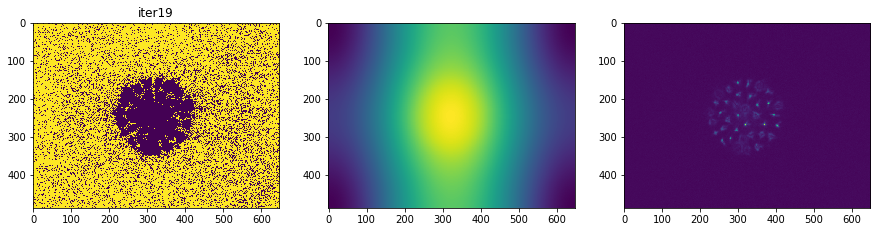

In [25]:

for n in range(nouter):
    #Solve linear system
    # (W + l*DtD)z = Wy
    zstar = sc.sparse.linalg.cgs(A, (W*psf).ravel(),x0=z.ravel(),maxiter = 100,tol=1000)
    #Update weights image
    z = np.reshape(zstar[0],sh)
    #
    W = p*(y>z) + (1-p) * (y<=z)
    ax[0].imshow(W)
    ax[0].set_title('iter{}'.format(n))
   
    ax[1].imshow(z)
   
    ax[2].imshow(psf - z)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(.1) 
                       
       
    

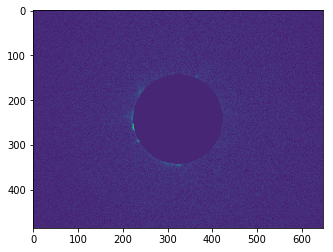

In [27]:
Nx = sh[1]
Ny = sh[0]
x = np.linspace(-Nx//2,Nx//2,Nx)+0
y = np.linspace(-Ny//2,Ny//2,Ny)+0
X,Y = np.meshgrid(x,y)
W = np.sqrt(X**2 + Y**2)>100;

def DtD(x,D):
    return(np.real(np.fft.ifft2(np.fft.fft2(x)*D)))


def als_lhs(z): #, W, lam, Ds, sh):
    # Compute (W+ lam*DtD)z
    z = np.reshape(z,sh)
    return (W*z + lam*DtD(z,Ds)).ravel()


#A = LinearOperator((np.prod(sh), np.prod(sh)), matvec = als_lhs)
plt.figure()
plt.imshow(W*psf)
lam = 100
z_manual = zstar
z_manual = sc.sparse.linalg.cgs(A, (W*psf).ravel(),x0=z_manual[0].ravel(),maxiter = 500,tol=.01)


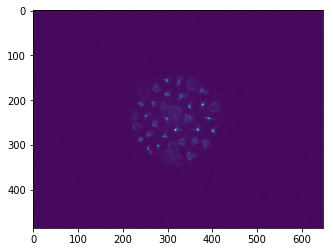

In [19]:
plt.figure()
plt.imshow(psf - np.reshape(z_manual[0],sh))
psf_bg_manual = psf-np.reshape(z_manual[0],sh)

In [28]:
psf_bg_auto = psf - z;
sc.io.savemat('/Users/nick.antipa/Documents/psf_manual_bg_nanoscribe_test_z175.mat',{'psf_man':psf_bg_manual,'psf_aut':psf_bg_auto},appendmat=False)


In [ ]:
plt.figure()
plt.plot(psf-np.reshape(z_manual[0],sh));
plt.ylim(-100,100)


In [ ]:
plt.figure()
plt.plot(psf-z)
plt.ylim(-10000,10000)

In [ ]:
plt.figure()
plt.plot(psf)
plt.ylim(-10000,10000)